In [1]:
#https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/

# Prepair Data

## Connect Neo4j

In [2]:
pip install node2vec

Note: you may need to restart the kernel to use updated packages.


## Import Required Packages

In [3]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from node2vec import Node2Vec
random_state = 77

## Load Data

In [4]:
file_name = 'drug_infection_disease'
df = pd.read_csv(f'{file_name}.csv')
df

,node_1,node_2
0,Lemierre's Syndrome,"Anti-Inflammatory Agents, Non-Steroidal"
1,Lemierre's Syndrome,Anti-Inflammatory Agents
2,Lemierre's Syndrome,"Diuretics, Potassium Sparing"
3,Lemierre's Syndrome,"Anti-Infective Agents, Local"
4,Lemierre's Syndrome,Analgesics
...,...,...
17165,West Nile Virus Infection,Rho(D) Immune Globulin
17166,West Nile Virus Infection,Immunologic Factors
17167,West Nile Virus Infection,"Antibodies, Monoclonal"
17168,West Nile Virus Infection,Vaccines


## Create Graph Object

In [5]:
G = nx.from_pandas_edgelist(df, "node_1", "node_2", create_using=nx.Graph())

## Visualize Graph

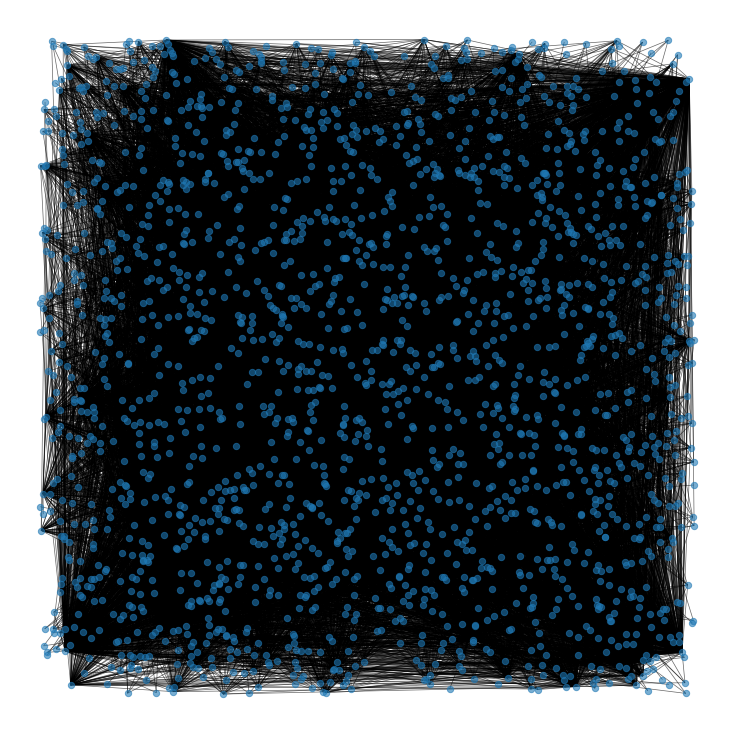

In [6]:
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=random_state)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

## Create Adjacency Matrix

In [7]:
node_list_1 = df['node_1'].tolist()
node_list_2 = df['node_2'].tolist()

# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

print('No of Node: ', len(node_list))
print('Graph Shape: ', adj_G.shape)
print('Adjacency Matrix')
adj_G

No of Node:  2089
Graph Shape:  (2089, 2089)
Adjacency Matrix


matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

## Find unconnected pair

In [8]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
data_i = tuple(zip(range(adj_G.shape[0]), node_list))
data_j = tuple(zip(range(adj_G.shape[1]), node_list))

for i, node_i in tqdm(data_i):
    for j, node_j in data_j:
        if i != j:
            if nx.shortest_path_length(G, node_i, node_j) <= 2:
                if adj_G[i,j] == 0:
                    all_unconnected_pairs.append([node_list[i], node_list[j]])


100%|██████████| 2089/2089 [04:28<00:00,  7.77it/s]


In [9]:
data = pd.DataFrame(all_unconnected_pairs, columns =['node_1', 'node_2']) 
data['link'] = 0

## Find connected pair

In [10]:
initial_node_count = len(G.nodes)

df_temp = df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(df.index.values):

    # remove a node pair and build a new graph
    G_temp = nx.from_pandas_edgelist(df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
    # check there is no spliting of graph and number of nodes is same
    if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
        omissible_links_index.append(i)
        df_temp = df_temp.drop(index = i)

100%|██████████| 17170/17170 [06:47<00:00, 42.16it/s] 


In [11]:
# create dataframe of removable edges
df_ghost = df.loc[omissible_links_index]

# add the target variable 'link'
df_ghost['link'] = 1

## Combine unconnected pair and connected pair

In [12]:
data = data.append(df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)
data['link'].value_counts()
data.to_pickle(f'{file_name}_raw_graph.pkl')

In [13]:
data = pd.read_pickle(f'{file_name}_raw_graph.pkl')

## Build Graph

In [14]:
# drop removable edges
df_partial = df.drop(index=df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(df_partial, "node_1", "node_2", create_using=nx.Graph())

## Embed node using Node2Vec (Dimensions = 50)

In [15]:
dimensions = 50

# Generate walks
node2vec = Node2Vec(G_data, dimensions=dimensions, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1, workers=8)

x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

Generating walks (CPU: 1): 100%|██████████| 50/50 [01:13<00:00,  1.46s/it]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


## Create and save train and test set (Dimensions = 50)

In [16]:
train_test_set = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                stratify=data['link'],
                                                random_state = random_state)

filename = f'{file_name}_train_test_set_{dimensions}.pkl'
with open(filename,'wb') as f:
    pickle.dump(train_test_set, f)

## Embed node using Node2Vec (Dimensions = 100)

In [17]:
dimensions = 100

# Generate walks
node2vec = Node2Vec(G_data, dimensions=dimensions, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1, workers=8)

x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

Generating walks (CPU: 1): 100%|██████████| 50/50 [01:11<00:00,  1.44s/it]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


## Create and save train and test set (Dimensions = 100)

In [18]:
train_test_set = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                stratify=data['link'],
                                                random_state = random_state)

filename = f'{file_name}_train_test_set_{dimensions}.pkl'
with open(filename,'wb') as f:
    pickle.dump(train_test_set, f)